# Sentimental Analysis

Sentiment analysis is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers.

Sentiment analysis faces a major hurdle due to the complex nature of human language. Textual data frequently incorporates sarcasm, irony, and other types of figurative language that can be hard to decipher using conventional approach


In this tutorial, we will try to learn how we can use Stanza and NLTK to do the sentimental Analysis

## Installations

In [1]:
%%capture
!pip install stanza datasets

## Setting Parameters

In [2]:
use_gpu = True
shrink_dataset = True

## Imports

In [3]:
import stanza
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
from collections import Counter
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.metrics import classification_report
from wordcloud import WordCloud


## Downloads

In [4]:
%%capture
stanza.download('en',logging_level='WARN') # download English model
nltk.download('stopwords',quiet=True)

## Dataset
We will use [Amazon US review dataset](https://huggingface.co/datasets/amazon_us_reviews) of 
hugging face.

As this dataset is huge, we will be using data of a subcategory i.e. Personal_Care_Appliances_v1_00

It has about 85981 reviews. 


In [5]:
%%capture
dataset = load_dataset('amazon_us_reviews','Personal_Care_Appliances_v1_00') 

Let's take a look at one sample record 

In [6]:
dataset['train'][0]

{'marketplace': 'US',
 'customer_id': '32114233',
 'review_id': 'R1QX6706ZWJ1P5',
 'product_id': 'B00OYRW4UE',
 'product_parent': '223980852',
 'product_title': 'Elite Sportz Exercise Sliders are Double Sided and Work Smoothly on Any Surface. Wide Variety of Low Impact Exercise’s You Can Do. Full Body Workout, Compact for Travel or Home Ab Workout',
 'product_category': 'Personal_Care_Appliances',
 'star_rating': 5,
 'helpful_votes': 0,
 'total_votes': 0,
 'vine': 0,
 'verified_purchase': 1,
 'review_headline': 'Good quality. Shipped',
 'review_body': 'Exactly as described. Good quality. Shipped fast',
 'review_date': '2015-08-31'}

In [7]:
dataset['train'].shape

(85981, 15)

Shrink dataset if set for faster execution

In [8]:
size = dataset['train'].shape[0]
if shrink_dataset:
  size  = 100

let's get the required data and label. We will use the review_body and star_rating to classify the sentiment.


## Data Analysis

In [9]:
def plot_pie(ratings,name):
  plt.pie(ratings.values(), labels=ratings.keys(), autopct='%1.1f%%')
  plt.title(f"Distribution of Star Ratings - {name}")
  plt.show()

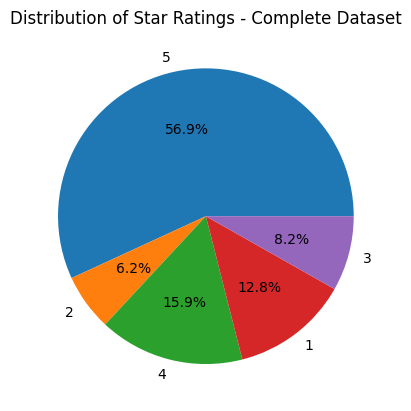

In [10]:
ratings = Counter(dataset['train']['star_rating'])
plot_pie(ratings, 'Complete Dataset')

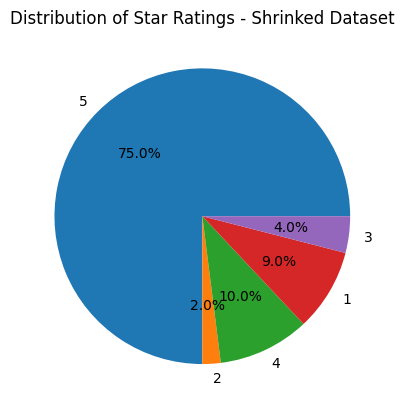

In [11]:
ratings = Counter(dataset['train']['star_rating'][0:size])
plot_pie(ratings, 'Shrinked Dataset')

Most of the ratings are 5, so we can expect more positive sentiments.

## Common Preprocessing

 `pre_process_ratings` function takes a list of ratings as input and map each rating to a sentiment value of 0, 1, or 2, representing negative, neutral, and positive sentiment, respectively. The output is a list of pre-processed sentiment values that can be used for further analysis or modeling.

In [12]:
def pre_process_ratings(ratings):
  sentiments  = []
  for rating in ratings:
    if rating <=2:
      sentiments.append(0)
    elif rating >=4:
      sentiments.append(2)
    else:
      sentiments.append(1)
  return sentiments

In [13]:
true_labels = pre_process_ratings(dataset['train']['star_rating'][0:size])

## Preprocessing Using Stanza

 `pre_process_review_texts` function takes a list of texts as input and applies pre-processing steps such as lowercasing, tokenization, lemmatization, and stop word(from nltk corpus) removal using the Stanza library. The output is a list of pre-processed text data that can be used for further analysis or modeling.

In [14]:
def pre_process_review_texts(nlp,texts):
  processed_texts = []
  for text in tqdm(texts):
    doc = nlp(text.lower())
    lemmatized_tokens= []
    for sentence in doc.sentences:
        for word in sentence.words:
          if word.lemma and word.lemma not in stopwords.words('english'):
            lemmatized_tokens.append(word.lemma)
    processed_text = ' '.join(lemmatized_tokens)
    processed_texts.append(processed_text)
  return processed_texts

Below code sets up a Stanza pipeline.
Here's what each of the parameters used in the Pipeline constructor means:

- lang='en': specifies that the language of the text data to be processed is English.
- processors='tokenize,lemma': specifies that two processing steps should be applied to the text data: tokenization (i.e., splitting the text into individual words or tokens) and lemmatization (i.e., reducing each word to its base form or lemma).
- logging_level='WARN': sets the logging level to "warning", which means that only warnings and errors will be logged during processing. This can be helpful for reducing the amount of output generated during processing.
- use_gpu: specifies whether to use the GPU (graphics processing unit) for processing


In [15]:
%%capture
nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma',logging_level='WARN',use_gpu=use_gpu)

In [16]:
processed_texts = pre_process_review_texts(nlp,dataset['train']['review_body'][0:size])

  0%|          | 0/100 [00:00<?, ?it/s]

Let's take a quick look at the word cloud of our processed text

In [17]:
def show_word_cloud(processed_texts, custom_stop_words= ['br']):
  word_cloud_stop_words = set(stopwords.words('english'))
  word_cloud_stop_words.update(custom_stop_words) 
  all_reviews = " ".join(review for review in processed_texts)
  wordcloud = WordCloud(stopwords=word_cloud_stop_words).generate(all_reviews)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


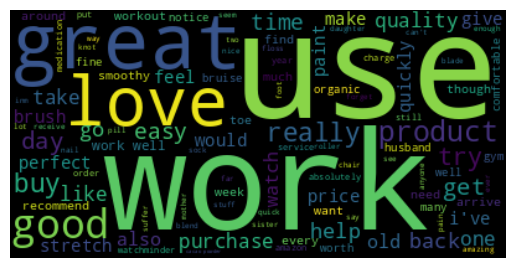

In [18]:
show_word_cloud(processed_texts)

## Sentimental Analysis Using Stanza

`get_sentiment` function performs sentiment analysis on a given review (multiple sentences) using a Stanza pipeline object, and returns the sentiment with the highest frequency in the review. For e.g. if in a review, more sentences belong to the 0 class (Negative Sentiment) then we will consider that a negative  review

In [19]:
def get_sentiment(stanza_sentiment_analyzer,text):
  sentiments = defaultdict(int)
  doc = stanza_sentiment_analyzer(text)
  total =0
  for sentence in doc.sentences:
    sentiments[sentence.sentiment]+=1
    total+=1
  all_values = dict([ (sentiment,sentiments[sentiment]/total) for sentiment in sentiments])
  sorted_values = sorted(all_values.items(), key=lambda x:x[1],reverse=True)
  return sorted_values[0][0]

`get_sentiments_using_stanza` function applies sentiment analysis using a Stanza pipeline object to a list of reviews and generates predicted labels.It also collects the true labels for these reviews. The output is a tuple containing two lists: predicted_sentiments and true_sentiments, which can be used for evaluating the performance of the sentiment analysis model.

In [20]:
def get_sentiments_using_stanza(stanza_sentiment_analyzer,texts,labels):
  predicted_sentiments =[]
  true_sentiments = []
  for idx,text in tqdm(enumerate(texts),total=len(texts)):
    try:
      sentiment = get_sentiment(stanza_sentiment_analyzer,text)
      predicted_sentiments.append(sentiment)
      true_sentiments.append(labels[idx])
    except IndexError:
       pass
  return predicted_sentiments,true_sentiments

In [21]:
%%capture
stanza_sentiment_analyzer = stanza.Pipeline(lang='en', processors='tokenize,sentiment',logging_level='WARN',use_gpu=use_gpu)

In [22]:
predicted_sentiments_stanza,true_sentiments = get_sentiments_using_stanza(stanza_sentiment_analyzer, processed_texts,true_labels)

  0%|          | 0/100 [00:00<?, ?it/s]

## Results Of Stanza Sentimental Analysis

In [23]:
print(classification_report(true_sentiments, predicted_sentiments_stanza))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.08      0.75      0.15         4
           2       0.96      0.60      0.74        85

    accuracy                           0.60       100
   macro avg       0.55      0.63      0.49       100
weighted avg       0.89      0.60      0.70       100



## NLTK provides a sentimental analyzer too, let's try that one as well

## Imports

In [24]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Downloads

In [25]:
%%capture
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('vader_lexicon',quiet=True)

## Preprocessing Using NLTK

 `pre_process_review_texts` function takes a list of texts as input and applies pre-processing steps such as lowercasing, tokenization, lemmatization, and stop word(from nltk corpus) removal using the **NLTK** library. The output is a list of pre-processed text data that can be used for further analysis or modeling.

In [26]:
def preprocess_review_texts_using_nltk(texts):
  processed_texts = []
  for text in tqdm(texts):
      tokens = word_tokenize(text.lower())
      filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
      lemmatizer = WordNetLemmatizer()
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
      processed_text = ' '.join(lemmatized_tokens)
      processed_texts.append(processed_text)
  return processed_texts


In [27]:
processed_texts_nltk = preprocess_review_texts_using_nltk(dataset['train']['review_body'][0:size])

  0%|          | 0/100 [00:00<?, ?it/s]

Let's take a quick look at the word cloud of our processed text

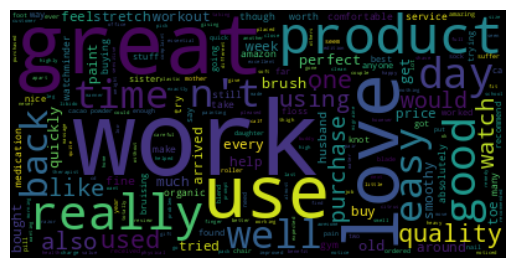

In [28]:
show_word_cloud(processed_texts_nltk)

## Sentimental Analysis Using NLTK

`get_sentiment_using_nltk` function applies sentiment analysis using a SentimentIntensityAnalyzer to a list of reviews and generates predicted labels.It also collects the true labels for these reviews. The output is a tuple containing two lists: predicted_sentiments and true_sentiments, which can be used for evaluating the performance of the sentiment analysis model.`

In [29]:
def get_sentiment_using_nltk(analyzer,texts,labels):
  predicted_sentiments =[]
  true_sentiments = []
  for idx,text in tqdm(enumerate(texts),total=len(texts)):
    try:
      scores = analyzer.polarity_scores(text)
      sentiment_score = scores['compound']
      predicted_sentiments.append(round(sentiment_score+1))
      true_sentiments.append(labels[idx])
    except IndexError:
       pass
  return predicted_sentiments,true_sentiments


In [30]:
analyzer = SentimentIntensityAnalyzer()
predicted_sentiments_nltk,true_sentiments = get_sentiment_using_nltk(analyzer, processed_texts_nltk,true_labels)

  0%|          | 0/100 [00:00<?, ?it/s]

## Results Of NLTK Sentimental Analysis

In [31]:
print(classification_report(true_sentiments, predicted_sentiments_nltk))

              precision    recall  f1-score   support

           0       0.50      0.18      0.27        11
           1       0.05      0.50      0.09         4
           2       0.96      0.65      0.77        85

    accuracy                           0.59       100
   macro avg       0.51      0.44      0.38       100
weighted avg       0.88      0.59      0.69       100



## Conclusion
Both of the Sentimental analyzers did not give great performance for our usecase. May be we can improve preprocessing to achieve a better performance. Though they are great for quick sentimental analysis. Training your own model can achieve better performance, but it's a time consuming process.